In [1]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd
import matplotlib as mpl
import math

import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS

In [2]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/appliedNNdata/17thRun/sub0/"

In [6]:
Ups4S_file = uproot.open(nfs_path + "Ups4S_NN_predicted.root:variables;1")
df_Ups4S = Ups4S_file.arrays(library="pd")

In [7]:
FSPs_file = uproot.open(nfs_path + "FSPs.root:variables;1")
df_FSPs = FSPs_file.arrays(library="pd")

In [8]:
evt_counter_file = uproot.open(nfs_path + "evt_counter.root:variables;1")
df_evt_counter = evt_counter_file.arrays(library="pd")

In [9]:
print(df_Ups4S.shape[0])
print(df_Ups4S.groupby(["__event__","__production__"]).ngroups)
print(df_Ups4S["__event__"].nunique())

3669693
197986
197986


## choose BCS and add labels

In [10]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 
BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')
print(BCS_df.shape[0])

197986


In [11]:
imputelist = [["abs_genUp4S_PDG_0_0",0],["abs_genUp4S_PDG_0_1",0],["abs_genUp4S_PDG_0_2",0],
              ["abs_genUp4S_PDG_1_0",0],["abs_genUp4S_PDG_1_1",0],["abs_genUp4S_PDG_1_2",0]
              ]
for impute in imputelist:
    column_name = impute[0]
    impute_val = impute[1]

    print(BCS_df[BCS_df[column_name].isna() == True].shape[0])
    mask = BCS_df[column_name].isna() == 1
    BCS_df.loc[mask, column_name] = impute_val
    print(BCS_df[BCS_df[column_name].isna() == True].shape[0])

0
0
0
0
30836
0
0
0
0
0
30601
0


In [12]:
def isDstlnu(s):
    isDstlnu = 0

    abs_genUp4S_PDG_0_0 = int(s["abs_genUp4S_PDG_0_0"])
    abs_genUp4S_PDG_0_1 = int(s["abs_genUp4S_PDG_0_1"])
    abs_genUp4S_PDG_0_2 = int(s["abs_genUp4S_PDG_0_2"])
                              
    abs_genUp4S_PDG_1_0 = int(s["abs_genUp4S_PDG_1_0"])
    abs_genUp4S_PDG_1_1 = int(s["abs_genUp4S_PDG_1_1"])
    abs_genUp4S_PDG_1_2 = int(s["abs_genUp4S_PDG_1_2"])
    
    if abs_genUp4S_PDG_0_0 == 413:
        if abs_genUp4S_PDG_0_1 == 11 or abs_genUp4S_PDG_0_1 == 13:
            if abs_genUp4S_PDG_0_2 == 12 or abs_genUp4S_PDG_0_2 == 14:              
                isDstlnu = 1
                                  
    if abs_genUp4S_PDG_1_0 == 413:
        if abs_genUp4S_PDG_1_1 == 11 or abs_genUp4S_PDG_1_1 == 13:
            if abs_genUp4S_PDG_1_2 == 12 or abs_genUp4S_PDG_1_2 == 14:              
                isDstlnu = 1        
        
    return isDstlnu

BCS_df['isDstlnu'] = BCS_df.apply(isDstlnu, axis=1)

In [13]:
def lep_typeMC(s):
    label = "none"
    if np.isnan(s["lep_mcPDG"]) == True:
        return label
    
    abs_lep_mcPDG = int(abs(s["lep_mcPDG"]))
    if abs_lep_mcPDG == 13:
        label = "mu"
    elif abs_lep_mcPDG == 11:
        label = "e" 
    return label

BCS_df['lep_typeMC'] = BCS_df.apply(lep_typeMC, axis=1)

def lep_type(s):
    label = "none"
    if np.isnan(s["lep_PDG"]) == True:
        return label
    
    abs_lep_PDG = int(abs(s["lep_PDG"]))
    if abs_lep_PDG == 13:
        label = "mu"
    elif abs_lep_PDG == 11:
        label = "e" 
    return label
BCS_df['lep_type'] = BCS_df.apply(lep_type, axis=1)

In [14]:
def lep_MC_truth(s):
    label = 0
    if np.isnan(s["lep_motherPDG"]) == True:
        return label
    if s["lep_typeMC"] == "none":
        return label
    
    abs_lep_motherPDG = int(abs(s["lep_motherPDG"]))
    if abs_lep_motherPDG == 511:
        label = 1
   
    return label

BCS_df['lep_MC_truth'] = BCS_df.apply(lep_MC_truth, axis=1)

In [15]:
BCS_df['isDstlnu'].mean()

0.19692806562080148

In [16]:
BCS_df['lep_MC_truth'].mean()

0.23753699756548444

In [17]:
BCS_df['custom_signal'] = (BCS_df['lep_MC_truth'] & BCS_df['isDstlnu'])

In [18]:
BCS_df['custom_signal'].mean()

0.1423181437071308

In [19]:
bins = np.linspace(-10, 10, 50)
BCS_df["dau1_cosThetaBetweenParticleAndNominalB"].hist(bins=bins)

<AxesSubplot:>

## add info about leps in Btag to data frame

In [20]:
df_FSPs["lep"] = ((df_FSPs["PDG"] == 11.) | (df_FSPs["PDG"] == 13.))

In [21]:
df_FSPs["Btag"] = ((df_FSPs["basf2_used"] == 1.) & (df_FSPs["basf2_Bsig"] == 0.))

In [22]:
df_FSPs["Btag_lep"] = ((df_FSPs["Btag"] == 1.) & (df_FSPs["lep"] == 1.))

In [23]:
df_FSPs["Btag_lep"].mean()

0.021669724443650392

In [24]:
N_Btag_lep = pd.DataFrame({'N_lep_Btag' : df_FSPs.groupby( ["__event__","Btag_lep"] ).size()}).reset_index()

N_Btag_lep[N_Btag_lep["Btag_lep"] == True]["N_lep_Btag"].sum()

96061

In [25]:
column_name = "N_lep_Btag"
impute_val = 0

mask = N_Btag_lep["Btag_lep"] == False
N_Btag_lep.loc[mask, column_name] = impute_val

N_Btag_lep["N_lep_Btag"].sum()

96061

In [26]:
N_Btag_lep = N_Btag_lep.sort_values("N_lep_Btag",ascending=False).drop_duplicates(subset=("__event__"), keep='first')
N_Btag_lep["N_lep_Btag"].sum()

96061

In [27]:
BCS_df = BCS_df.merge(N_Btag_lep[["__event__","N_lep_Btag"]], how='inner', on="__event__")

In [28]:
BCS_df["N_lep_Btag"].sum()

96061

## save df with labels

In [29]:
BCS_df.to_csv(nfs_path + "BCS_df_puriEff.csv")
#df_FSPs.to_csv(nfs_path + "df_FSPs_puriEff.csv")
df_evt_counter.to_csv(nfs_path + "df_evt_counter_puriEff.csv")

In [30]:
print("worked")

worked


## load df with labels

In [3]:
BCS_df = pd.read_csv(nfs_path + "BCS_df_puriEff.csv")
#df_FSPs = pd.read_csv(nfs_path + "df_FSPs_puriEff.csv")
df_evt_counter = pd.read_csv(nfs_path + "df_evt_counter_puriEff.csv")

<AxesSubplot:>

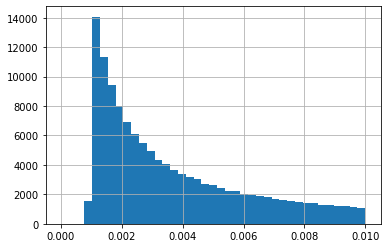

In [4]:
bins=np.linspace(0, 0.01, 40)
BCS_df["dau0_dau0_sigProb"].hist(bins=bins)

## calculate eff. and purity for all cuts separately

In [5]:
#N_evts_processed = df_evt_counter.shape[0]
N_evts_processed = 189000 * 255 # 189000 evts for each of the 255 files processed (one sub)

correction_factor = df_evt_counter.shape[0] / N_evts_processed 
N_evts_expected = correction_factor * N_evts_processed * 0.3049 * 0.099  # expected D*lnu (BR:4.95% for each e and mu) 
                                                  # with specific D0 modes (BR:30.49%) events

print("N_evts_expected:", N_evts_expected)
print("correction_factor:", correction_factor)

N_evts_expected: 1243587.4528869002
correction_factor: 0.8548338831829028


In [6]:
def append_lists(df, effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec):
    num_evts = df.shape[0]
    efficiency = num_evts / N_evts_expected
    N_selec.append(num_evts)
    effs.append(efficiency)

    purity_Dstlnu = df[df["isDstlnu"] == 1].shape[0] / num_evts
    purities_Dstlnu.append(purity_Dstlnu)
    N_pure.append(df[df["isDstlnu"] == 1].shape[0])
    purity_DstAndLep = df[df["custom_signal"] == 1].shape[0] / num_evts
    purities_DstAndLep.append(purity_DstAndLep)
    
    return effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec

In [68]:
cut_names = []
effs=[]
N_pure=[]
N_selec=[]
purities_Dstlnu=[]
purities_DstAndLep=[]
#######################################
cut_names.append("no cuts")

effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(BCS_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag Mbc")
dau0_Mbc_lower = 5.00

cut_df = BCS_df[BCS_df.dau0_Mbc > dau0_Mbc_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag deltaE")
dau0_deltaE_lim = 0.5
dau0_deltaE_center = -1.5

cut_df = BCS_df[(BCS_df.dau0_deltaE < dau0_deltaE_center + dau0_deltaE_lim) & 
                (BCS_df.dau0_deltaE >  dau0_deltaE_center - dau0_deltaE_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("foxWolframR2")
foxWolframR2_lim = 0.3

cut_df = BCS_df[(BCS_df.foxWolframR2 < foxWolframR2_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst_pt")
Dst_pt_upper = 2.4

cut_df = BCS_df[(BCS_df.Dst_pt < Dst_pt_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("lep_pt")
lep_pt_lower = 0.7

cut_df = BCS_df[(BCS_df.lep_pt > lep_pt_lower)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("D0 mass")
D_M_upper = 1.95
D_M_lower = 1.8

cut_df = BCS_df[(BCS_df.D_M > D_M_lower) & (BCS_df.D_M < D_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst mass")
Dst_M_lower = 1.8
Dst_M_upper = 2.2

cut_df = BCS_df[(BCS_df.Dst_M > Dst_M_lower) & (BCS_df.Dst_M < Dst_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("hadr. Btag")
cut_df = BCS_df[(BCS_df.N_lep_Btag == 0)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("HcSigProb>0.01")
dau0_dau0_sigProb_lower = 0.01

cut_df = BCS_df[BCS_df.dau0_dau0_sigProb > dau0_dau0_sigProb_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("SigProb>0.1")
dau0_dau0_sigProb_lower = 0.1

cut_df = BCS_df[BCS_df.dau0_dau0_sigProb > dau0_dau0_sigProb_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################

In [69]:
eff_and_pur = pd.DataFrame({'cut_name' : cut_names,
                            'N tagged evts' : N_selec,
                            'N tagged signal evts' : N_pure,
                           'efficiency' : effs,
                           'purity_Dst' : purities_Dstlnu,
                           'purity_DstAndLep' : purities_DstAndLep})

In [70]:
eff_and_pur

,cut_name,N tagged evts,N tagged signal evts,efficiency,purity_Dst,purity_DstAndLep
0,no cuts,197986,38989,0.159206,0.196928,0.142318
1,Btag Mbc,153266,31561,0.123245,0.205923,0.160035
2,Btag deltaE,59644,16193,0.047961,0.271494,0.196985
3,foxWolframR2,190977,36410,0.153569,0.190651,0.137959
4,Dst_pt,197604,38952,0.158898,0.197122,0.142507
5,lep_pt,69156,27150,0.055610,0.392591,0.366722
6,D0 mass,3816,578,0.003069,0.151468,0.096698
7,Dst mass,19650,3316,0.015801,0.168753,0.108855
8,hadr. Btag,121124,25762,0.097399,0.212691,0.155205
9,HcSigProb>0.01,72130,14511,0.058002,0.201178,0.150589


In [71]:
eff_and_pur.shape[0]

11

In [72]:
eff_and_pur.cut_name

0            no cuts
1           Btag Mbc
2        Btag deltaE
3       foxWolframR2
4             Dst_pt
5             lep_pt
6            D0 mass
7           Dst mass
8         hadr. Btag
9     HcSigProb>0.01
10       SigProb>0.1
Name: cut_name, dtype: object

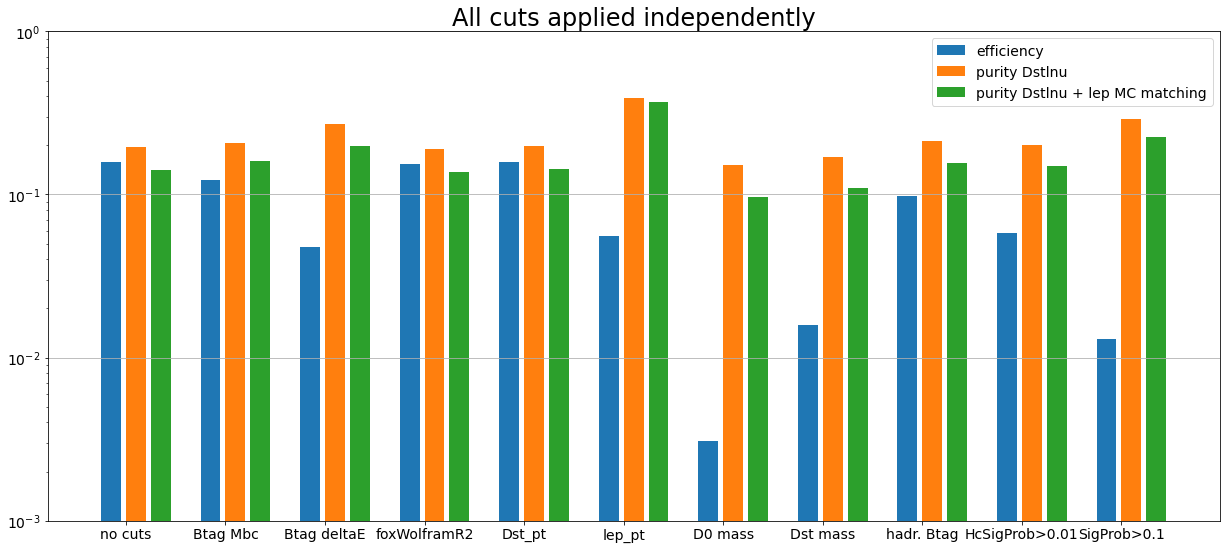

In [73]:
plt.rcParams["figure.figsize"] = (21,9)
plt.rcParams.update({'font.size': 14})

ind = np.arange(eff_and_pur.shape[0])
width = 0.2 
shift = 0.25

plt.title("All cuts applied independently",fontsize=24)
plt.bar(ind -shift, eff_and_pur['efficiency'], width, label='efficiency')
plt.bar(ind +0.0, eff_and_pur['purity_Dst'], width, label='purity Dstlnu')
plt.bar(ind +shift, eff_and_pur['purity_DstAndLep'], width, label='purity Dstlnu + lep MC matching')
plt.xticks((ind + width / 2)-width, eff_and_pur.cut_name) 
plt.yscale('log')
plt.ylim(ymax = 1, ymin = 0.001)
plt.legend()
plt.grid(axis='y')

plt.savefig('plots/efficiency_and_purity_singleCuts.pdf')
#plt.show()

## all cuts adding up

In [74]:
cut_names = []
effs=[]
N_pure=[]
N_selec=[]
purities_Dstlnu=[]
purities_DstAndLep=[]
#######################################
cut_names.append("no cuts")
cut_df = BCS_df

effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag Mbc")

cut_df = cut_df[cut_df.dau0_Mbc > dau0_Mbc_lower]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Btag deltaE")

cut_df = cut_df[(cut_df.dau0_deltaE < dau0_deltaE_center + dau0_deltaE_lim) & 
                (cut_df.dau0_deltaE >  dau0_deltaE_center - dau0_deltaE_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("foxWolframR2")

cut_df = cut_df[(cut_df.foxWolframR2 < foxWolframR2_lim)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst_pt")

cut_df = cut_df[(cut_df.Dst_pt < Dst_pt_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("lep_pt")

cut_df = cut_df[(cut_df.lep_pt > lep_pt_lower)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("D0 mass")

cut_df = cut_df[(cut_df.D_M > D_M_lower) & (cut_df.D_M < D_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("Dst mass")

cut_df = cut_df[(cut_df.Dst_M > Dst_M_lower) & (cut_df.Dst_M < Dst_M_upper)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################
#######################################
cut_names.append("fully hadr. Btag")
cut_df = cut_df[(cut_df.N_lep_Btag == 0)]
effs, purities_Dstlnu, purities_DstAndLep, N_pure, N_selec = append_lists(cut_df, effs, 
                        purities_Dstlnu, purities_DstAndLep, N_pure, N_selec)
#######################################

In [75]:
eff_and_pur_addingUp = pd.DataFrame({'cut_name' : cut_names,
                            'N tagged evts' : N_selec,
                            'N tagged signal evts' : N_pure,
                           'efficiency' : effs,
                           'purity_Dst' : purities_Dstlnu,
                           'purity_DstAndLep' : purities_DstAndLep})
eff_and_pur_addingUp

,cut_name,N tagged evts,N tagged signal evts,efficiency,purity_Dst,purity_DstAndLep
0,no cuts,197986,38989,0.159206,0.196928,0.142318
1,Btag Mbc,153266,31561,0.123245,0.205923,0.160035
2,Btag deltaE,46442,12805,0.037345,0.275720,0.216184
3,foxWolframR2,44684,11988,0.035932,0.268284,0.210791
4,Dst_pt,44620,11980,0.035880,0.268489,0.210959
5,lep_pt,19047,8980,0.015316,0.471465,0.446370
6,D0 mass,267,112,0.000215,0.419476,0.382022
7,Dst mass,172,83,0.000138,0.482558,0.447674
8,fully hadr. Btag,99,52,0.000080,0.525253,0.474747


In [76]:
eff_and_pur_addingUp["cut_name"]

0             no cuts
1            Btag Mbc
2         Btag deltaE
3        foxWolframR2
4              Dst_pt
5              lep_pt
6             D0 mass
7            Dst mass
8    fully hadr. Btag
Name: cut_name, dtype: object

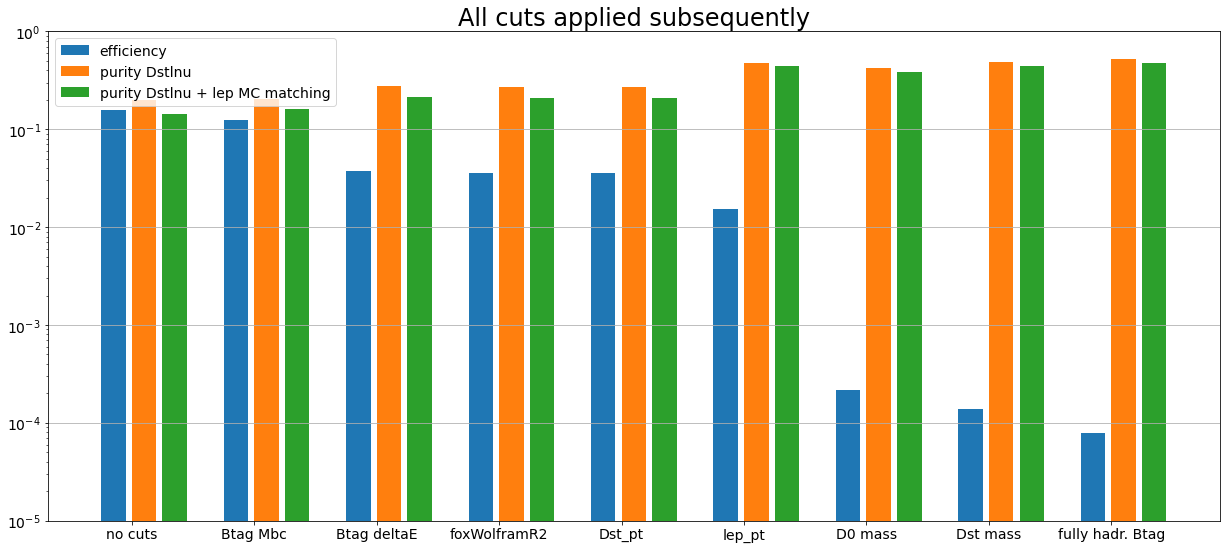

In [77]:
plt.rcParams["figure.figsize"] = (21,9)
plt.rcParams.update({'font.size': 14})

ind = np.arange(eff_and_pur_addingUp.shape[0])
width = 0.2
shift = 0.25

plt.title("All cuts applied subsequently",fontsize=24)

plt.bar(ind -shift, eff_and_pur_addingUp['efficiency'], width, label='efficiency')
plt.bar(ind +0.0, eff_and_pur_addingUp['purity_Dst'], width, label='purity Dstlnu')
plt.bar(ind +shift, eff_and_pur_addingUp['purity_DstAndLep'], width, label='purity Dstlnu + lep MC matching')
plt.xticks((ind + width / 2)-width, eff_and_pur_addingUp.cut_name) 
plt.yscale('log')
plt.ylim(ymax = 1, ymin = 0.00001)
plt.grid(axis='y')

plt.legend()
plt.savefig('plots/efficiency_and_purity_stackedCuts.pdf')
#plt.show()

In [79]:
plot_vars=["dau0_Mbc","dau0_deltaE","foxWolframR2","Dst_pt","lep_pt","D_M","Dst_M","N_lep_Btag"]

In [80]:
bins_dict = {
    "dau0_Mbc":  np.linspace(4, 5.5, 40),
    "dau0_deltaE":   np.linspace(-5, 5, 40),
    "foxWolframR2":   np.linspace(0, 0.5, 40),
    "Dst_pt":   np.linspace(0, 3, 40),
    "lep_pt":   np.linspace(0, 3, 40),
    "D_M":   np.linspace(0, 4, 40),
    "Dst_M":   np.linspace(0, 4, 40),
    "N_lep_Btag":   np.linspace(0, 5, 6)
    }

0 0 dau0_Mbc
1 0 dau0_deltaE
2 0 foxWolframR2
3 0 Dst_pt
0 1 lep_pt
1 1 D_M
2 1 Dst_M
3 1 N_lep_Btag


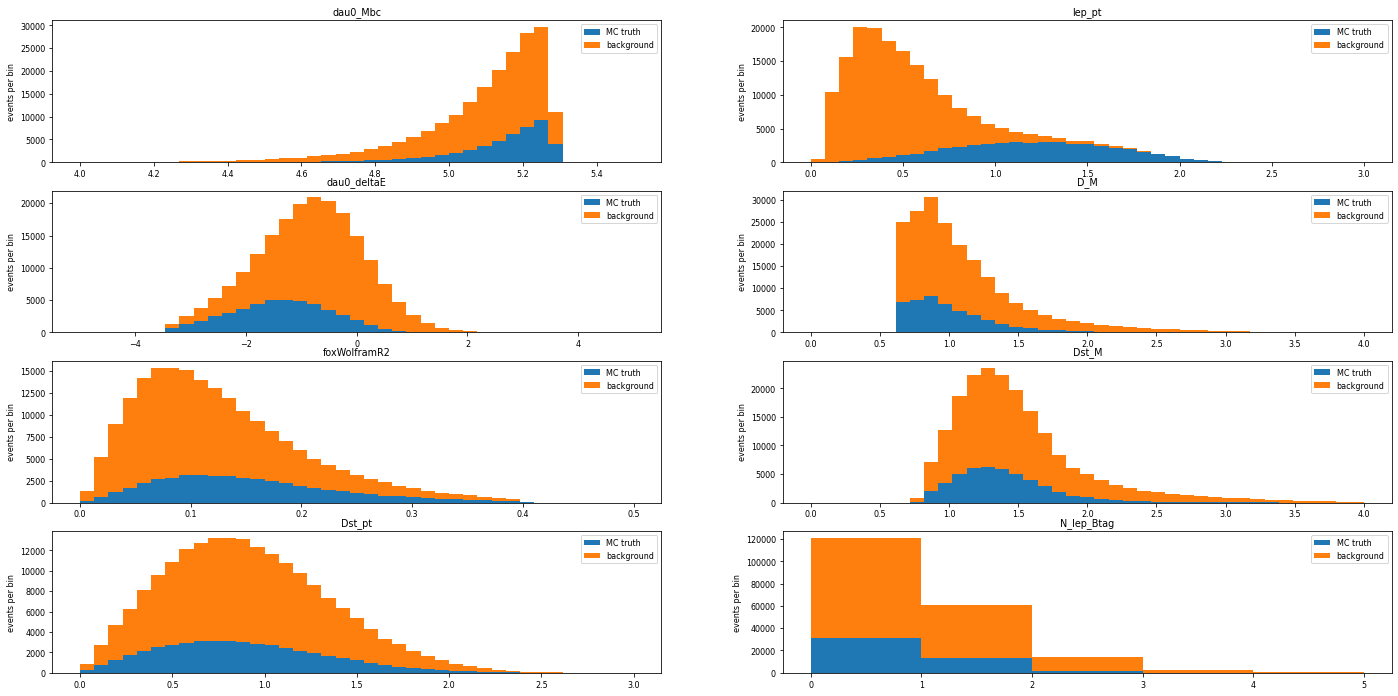

In [81]:
dim_x = 4
fig, axs = plt.subplots(dim_x, 2)
fig.set_size_inches(24, 12)
font_size=8
plt.rcParams.update({'font.size': font_size})

mcTruth_df = BCS_df[BCS_df["lep_MC_truth"] == 1]
mcBG_df = BCS_df[BCS_df["lep_MC_truth"] == 0]

for i, var in enumerate(plot_vars):
    
    idx=i % dim_x
    idy=math.floor(i/dim_x)
    print(idx, idy, var)
    
    ax = axs[idx, idy]   
    
    bins = bins_dict[var]
    ax.set_title(f'{var}')

    #ax.set_xlabel(r'number of wrong predictions per event')
    ax.set_ylabel("events per bin",fontsize=font_size)
    

    
    #plt.xticks(np.arange(0, num_steps, step=1))
    ax.hist([mcTruth_df[var],mcBG_df[var]], bins, stacked=True, density=False, alpha=1,
           label=["MC truth","background"])
    

    
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='both', which='minor', labelsize=font_size)

    ax.legend(loc='upper right')

    #plt.grid()

plt.savefig('plots/efficiency_and_purity_variablesDistris.pdf')

In [82]:
BCS_df["Ds_massDifference"] = BCS_df["Dst_M"] - BCS_df["D_M"]

mcTruth_df = BCS_df[BCS_df["lep_MC_truth"] == 1]
mcBG_df = BCS_df[BCS_df["lep_MC_truth"] == 0]

## look at D mass for different decay modes of D0

In [85]:
BCS_df["D_decayModeID"].value_counts()

21001.0    125577
21003.0     67593
21002.0      3047
21004.0      1769
Name: D_decayModeID, dtype: int64

array([[<AxesSubplot:title={'center':'21001.0'}>,
        <AxesSubplot:title={'center':'21002.0'}>],
       [<AxesSubplot:title={'center':'21003.0'}>,
        <AxesSubplot:title={'center':'21004.0'}>]], dtype=object)

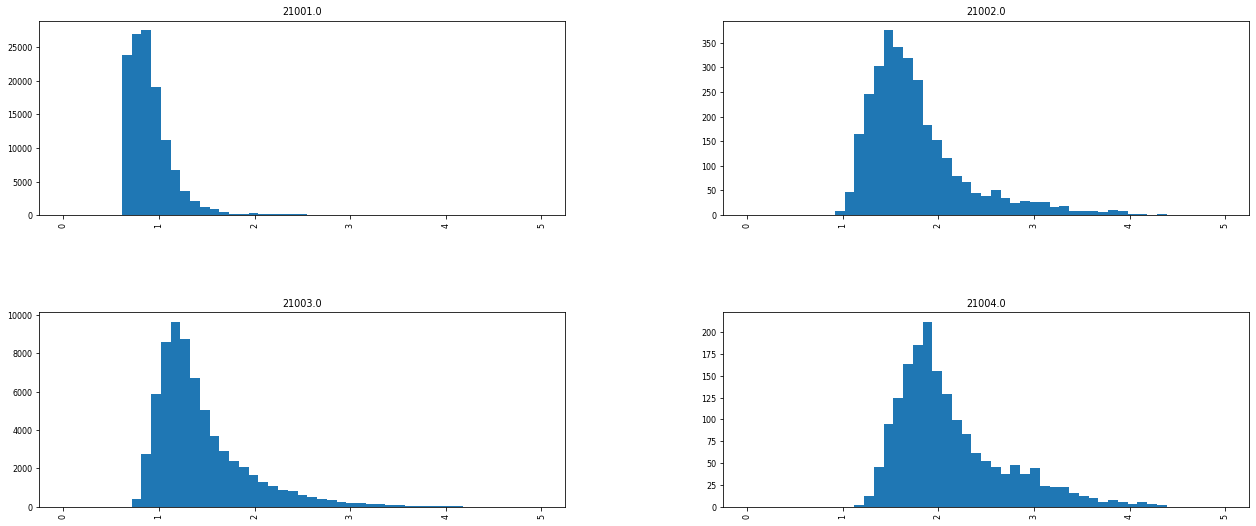

In [88]:
bins = np.linspace(0, 5, 50)
BCS_df.hist("D_M", by = "D_decayModeID", bins=bins)

In [87]:
#D0:kpi  -> dmID=21001
#D0:kpipipi -> dmID=21002
#D0:kpipi0 -> dmID=21003
#D0:kpipipipi0 -> dmID=21004

In [100]:
Dmode_dict = {
    21001.0: "K $\pi$",
    21003.0: "K 3$\pi$",
    21002.0: "K $\pi$ $\pi^0$",
    21004.0: "K 3$\pi$ $\pi^0$"
}

0 0 D_M
1 0 D_M
0 1 D_M
1 1 D_M


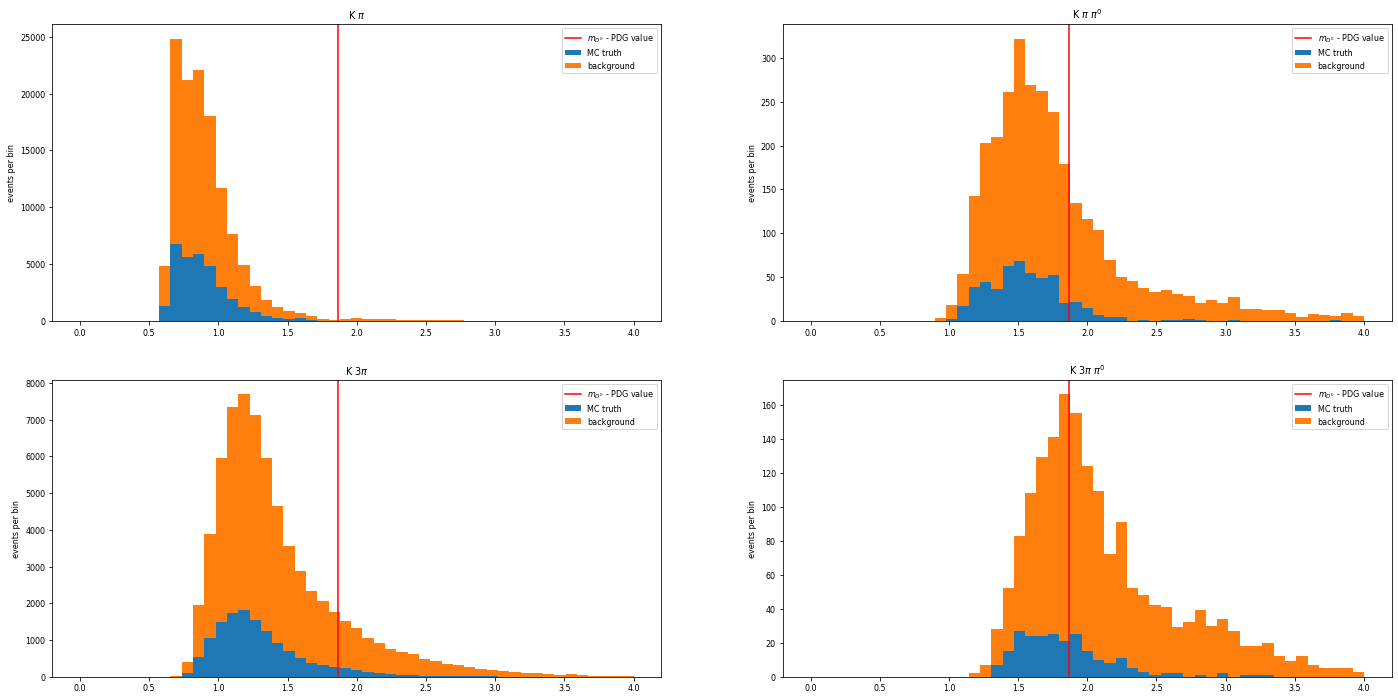

In [101]:
dim_x = 2
fig, axs = plt.subplots(dim_x, 2)
fig.set_size_inches(24, 12)
font_size=8
plt.rcParams.update({'font.size': font_size})

mcTruth_df = BCS_df[BCS_df["lep_MC_truth"] == 1]
mcBG_df = BCS_df[BCS_df["lep_MC_truth"] == 0]

D_modes=[21001.0, 21003.0, 21002.0, 21004.0]

for i, Dmode in enumerate(D_modes):
    
    var = "D_M"
    
    idx=i % dim_x
    idy=math.floor(i/dim_x)
    print(idx, idy, var)
    
    ax = axs[idx, idy]   
    
    bins = np.linspace(0, 4, 50)
    ax.set_title(f'{Dmode_dict[Dmode]}')

    #ax.set_xlabel(r'number of wrong predictions per event')
    ax.set_ylabel("events per bin",fontsize=font_size)
    
    mcTruth_df_Dmode = mcTruth_df[mcTruth_df["D_decayModeID"] == Dmode]
    mcBG_df_Dmode = mcBG_df[mcBG_df["D_decayModeID"] == Dmode]
    
    D0_mass = 1.86483
    ax.axvline(x=D0_mass, color='r', label='$m_{D^0}$ - PDG value')
    
    
    #plt.xticks(np.arange(0, num_steps, step=1))
    ax.hist([mcTruth_df_Dmode[var],mcBG_df_Dmode[var]], bins, stacked=True, density=False, alpha=1,
           label=["MC truth","background"])
    

    
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.tick_params(axis='both', which='minor', labelsize=font_size)

    ax.legend(loc='upper right')

    #plt.grid()

plt.savefig('plots/Dmass_per_decayMode.pdf')

## plot mass difference D* - D0

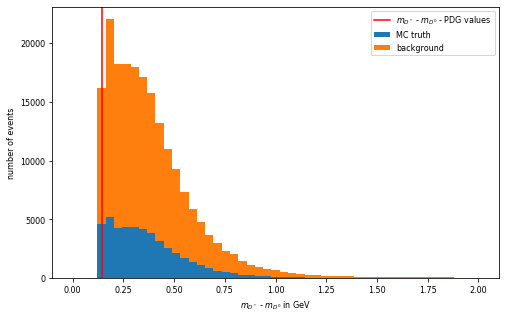

In [67]:
fig, ax = plt.subplots()
#fig.suptitle(r'$D^*$ - $D^0$ mass')

bins = np.linspace(0, 2, 50)

fig.set_size_inches(8, 5)

ax.set_xlabel(r'$m_{D^*}$ - $m_{D^0}$ in GeV')
ax.set_ylabel(r'number of events')


massDiff = 2.01026 - 1.86483 # D*+ - D0 mass
plt.axvline(x=massDiff, color='r', label='$m_{D^*}$ - $m_{D^0}$ - PDG values')

ax.hist([mcTruth_df["Ds_massDifference"],mcBG_df["Ds_massDifference"]], bins, stacked=True, density=False, alpha=1,
       label=["MC truth","background"])



ax.legend(loc='upper right')

#plt.grid()


plt.savefig('plots/Dst_D_massDifference.pdf')

In [39]:
print("end reached")

end reached
